DATA SET LINK: https://drive.google.com/drive/folders/1l30740powJNZJGwSdU09jwC_-L6H0u5D?usp=sharing 

**DATA AUGMENTATION**

In [1]:
import os
from PIL import Image
import random

# Dataset paths
dataset_dir = "dataset"
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

# Output directorie
augmented_dir = os.path.join(dataset_dir, "augmented_dataset")
os.makedirs(augmented_dir, exist_ok=True)

for dataset in ["train", "test"]:
    dataset_input_dir = os.path.join(dataset_dir, dataset)
    dataset_output_dir = os.path.join(augmented_dir, dataset)
    os.makedirs(dataset_output_dir, exist_ok=True)

    for category in ["NORMAL", "PNEUMONIA"]:
        input_dir = os.path.join(dataset_input_dir, category)
        output_dir = os.path.join(dataset_output_dir, category)
        os.makedirs(output_dir, exist_ok=True)

        for file in os.listdir(input_dir):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(input_dir, file)
                img = Image.open(img_path)

                img.save(os.path.join(output_dir, file))

                rotation_angle = random.choice([90, 180, 270])
                rotated_img = img.rotate(rotation_angle)

                rotated_file_name = f"{os.path.splitext(file)[0]}_rotated_{rotation_angle}.jpeg"
                rotated_img.save(os.path.join(output_dir, rotated_file_name))

print("Augmentation complete.")


Augmentation complete.


**DATA SPLIT TO TEST AND TRAIN**

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Dataset paths
dataset_dir = "dataset/augmented_dataset"
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

# Combined folder
combined_dir = os.path.join(dataset_dir, "combined")
os.makedirs(combined_dir, exist_ok=True)

for folder in ["NORMAL", "PNEUMONIA"]:
    os.makedirs(os.path.join(combined_dir, folder), exist_ok=True)
    for subset in [train_dir, test_dir]:
        source_dir = os.path.join(subset, folder)
        for file in os.listdir(source_dir):
            shutil.move(os.path.join(source_dir, file), os.path.join(combined_dir, folder))

for folder in ["NORMAL", "PNEUMONIA"]:
    files = os.listdir(os.path.join(combined_dir, folder))
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

    train_folder = os.path.join(train_dir, folder)
    os.makedirs(train_folder, exist_ok=True)
    for file in train_files:
        shutil.move(os.path.join(combined_dir, folder, file), os.path.join(train_folder, file))

    test_folder = os.path.join(test_dir, folder)
    os.makedirs(test_folder, exist_ok=True)
    for file in test_files:
        shutil.move(os.path.join(combined_dir, folder, file), os.path.join(test_folder, file))

shutil.rmtree(combined_dir)

print("Dataset split into 80:20 ratio")

Dataset split into 80:20 ratio


**IMAGE RESIZE**

In [ ]:
import os
from PIL import Image

def resize_image(size):
    PATH_I = 'dataset/augmented_dataset'
    PATH_O = 'new'
    input_dirs = [f'{PATH_I}/train', f'{PATH_I}/test'] 
    output_dirs = [f'{PATH_O}_resized_{size}/train',  
                   f'{PATH_O}_resized_{size}/test']

    target_size = (size, size) 

    for output_dir in output_dirs:
        os.makedirs(output_dir, exist_ok=True)

    def resize_with_padding(image, target_size):
        img_ratio = image.width / image.height
        target_ratio = target_size[0] / target_size[1]

        if img_ratio > target_ratio:
            new_width = target_size[0]
            new_height = round(new_width / img_ratio)
        else:
            new_height = target_size[1]
            new_width = round(new_height * img_ratio)

        img_resized = image.resize((new_width, new_height), Image.LANCZOS)

        new_image = Image.new("RGB", target_size, (0, 0, 0))
        new_image.paste(img_resized, ((target_size[0] - new_width) // 2, (target_size[1] - new_height) // 2))

        return new_image

    for i in range(2):
        for root, _, files in os.walk(input_dirs[i]):
            for file in files:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img_resized = resize_with_padding(img, target_size)
                output_path = os.path.join(output_dirs[i], file)
                img_resized.save(output_path)
resize_image(224)

**Example of Dataset**

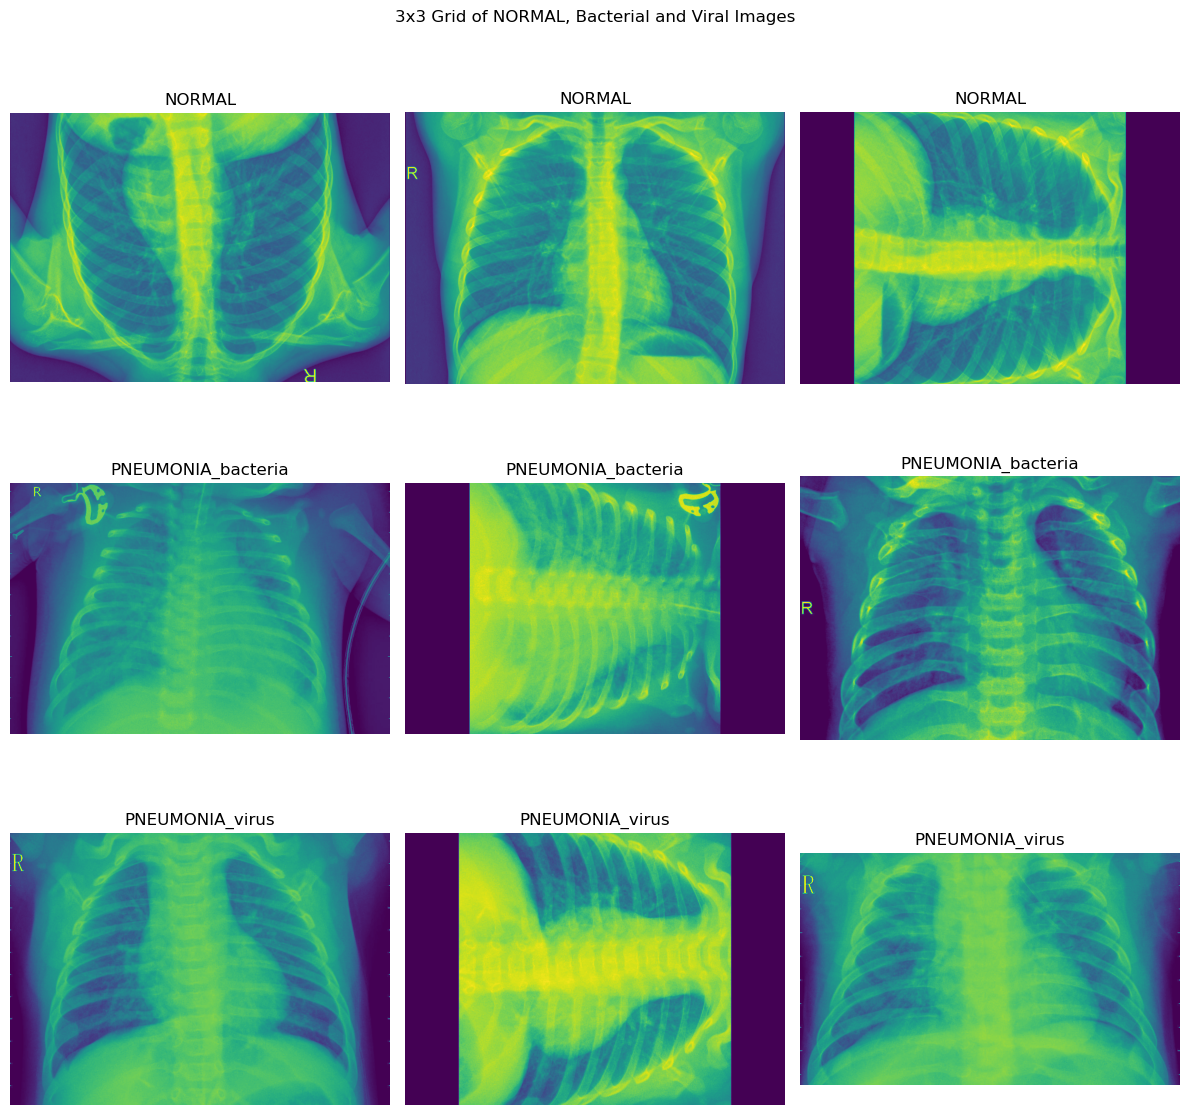

In [17]:
import matplotlib.pyplot as plt
import os
from PIL import Image
train_path = 'dataset/augmented_dataset/train'
categories = ['NORMAL', 'PNEUMONIA']
examples = {'NORMAL': [], 'PNEUMONIA_bacteria': [], 'PNEUMONIA_virus': []}

for category in categories:
    category_path = os.path.join(train_path, category)
    for img_name in os.listdir(category_path):
        if category == 'PNEUMONIA':
            if 'bacteria' in img_name.lower() and len(examples['PNEUMONIA_bacteria']) < 3:
                img_path = os.path.join(category_path, img_name)
                img = Image.open(img_path)
                examples['PNEUMONIA_bacteria'].append((img, 'PNEUMONIA_bacteria'))
            elif 'virus' in img_name.lower() and len(examples['PNEUMONIA_virus']) < 3:
                img_path = os.path.join(category_path, img_name)
                img = Image.open(img_path)
                examples['PNEUMONIA_virus'].append((img, 'PNEUMONIA_virus'))
        elif category == 'NORMAL' and len(examples['NORMAL']) < 3:
            img_path = os.path.join(category_path, img_name)
            img = Image.open(img_path)
            examples['NORMAL'].append((img, 'NORMAL'))
        if len(examples['NORMAL']) >= 3 and len(examples['PNEUMONIA_bacteria']) >= 3 and len(examples['PNEUMONIA_virus']) >= 3:
            break

combined_examples = examples['NORMAL'] + examples['PNEUMONIA_bacteria'] + examples['PNEUMONIA_virus']

fig, axs = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('3x3 Grid of NORMAL, Bacterial and Viral Images')

for i, (img, label) in enumerate(combined_examples):
    row, col = divmod(i, 3)
    axs[row, col].imshow(img)
    axs[row, col].axis('off')
    axs[row, col].set_title(label)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


**Images into a NumPy array format**

In [80]:
import os
from PIL import Image
import numpy as np
from tensorflow.keras.utils import img_to_array
from tqdm import tqdm  

def convert_images_to_arrays(input_directory, rgb=True, classes=2, all=True):
    image_data = []
    label_data = []

    for filename in tqdm(os.listdir(input_directory)):
        if all or ('IM' not in filename and 'NORMAL' not in filename):
            image_path = os.path.join(input_directory, filename)
            if rgb:
                image = Image.open(image_path)
            else:
                image = Image.open(image_path).convert('L')  # Convert to grayscale
            image_array = img_to_array(image) / 255.0  # Normalize pixel values to [0, 1]
            image_data.append(image_array)

            # Assign labels based on filename
            if 'IM' in filename or 'NORMAL' in filename:
                label_data.append(0)  # 0 for NORMAL
            elif 'bacteria' in filename:
                label_data.append(1)  # 1 for bacterial pneumonia
            elif 'virus' in filename:
                if classes == 2:
                    label_data.append(1)  # 1 for pneumonia in 2-class case
                elif classes == 3:
                    label_data.append(2)  # 2 for viral pneumonia in 3-class case

    # Convert lists to numpy arrays
    X = np.array(image_data)
    y = np.array(label_data)
    print(f"Total images loaded: {len(X)}, Total labels: {len(y)}")

    return X, y

In [81]:
X_train_f, y_train_f = convert_images_to_arrays('new_resized_224/train', rgb = False, classes=3)
X_test_f, y_test_f = convert_images_to_arrays('new_resized_224/test', rgb= False, classes =3)

  0%|          | 0/9368 [00:00<?, ?it/s]

100%|██████████| 9368/9368 [00:04<00:00, 1904.95it/s]


Total images loaded: 9368, Total labels: 9368


100%|██████████| 2344/2344 [00:01<00:00, 1343.90it/s]


Total images loaded: 2344, Total labels: 2344


In [82]:
import tensorflow as tf
import numpy as np
import random

# Set seeds for reproducibility
tf.random.set_seed(907)
np.random.seed(907)
random.seed(907)

**MODEL 1. CUSTOMCNN**

In [ ]:
X_train_f, y_train_f = convert_images_to_arrays('new_resized_224/train', rgb = False, classes=3)
X_test_f, y_test_f = convert_images_to_arrays('new_resized_224/test', rgb= False, classes=3)

100%|██████████| 9368/9368 [00:04<00:00, 1890.84it/s]


Total images loaded: 9368, Total labels: 9368


100%|██████████| 2344/2344 [00:01<00:00, 1917.67it/s]


Total images loaded: 2344, Total labels: 2344


In [83]:
from sklearn.model_selection import train_test_split
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(X_train_f, y_train_f, test_size=0.1, random_state=907)
print(f"Training samples: {len(X_train_f)}, Validation samples: {len(X_val_f)}")

Training samples: 8431, Validation samples: 937


In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

model_1 = Sequential()

model_1.add(Conv2D(64, (11, 11), input_shape=(224, 224, 1), kernel_regularizer=l2(0.001))) 
model_1.add(MaxPooling2D((2, 2)))
model_1.add(LeakyReLU(alpha=0.1))

model_1.add(Conv2D(64, (7, 7), kernel_regularizer=l2(0.001))) 
model_1.add(LeakyReLU(alpha=0.1))
model_1.add(MaxPooling2D((2, 2)))

model_1.add(Conv2D(64, (5, 5), kernel_regularizer=l2(0.001))) 
model_1.add(LeakyReLU(alpha=0.1))
model_1.add(MaxPooling2D((2, 2)))

model_1.add(Conv2D(128, (3, 3), kernel_regularizer=l2(0.001)))  
model_1.add(LeakyReLU(alpha=0.1))

model_1.add(Conv2D(128, (3, 3), kernel_regularizer=l2(0.001)))
model_1.add(LeakyReLU(alpha=0.1))
model_1.add(MaxPooling2D((2, 2)))

model_1.add(Flatten())

model_1.add(Dense(1024, kernel_regularizer=l2(0.001)))
model_1.add(LeakyReLU(alpha=0.2))
model_1.add(Dropout(0.3))

model_1.add(Dense(256, kernel_regularizer=l2(0.001)))
model_1.add(LeakyReLU(alpha=0.2))

model_1.add(Dense(64, kernel_regularizer=l2(0.001))) 
model_1.add(LeakyReLU(alpha=0.2))

model_1.add(Dense(3, activation='softmax'))

model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_1_checkpoint.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='min')

model_1.summary()


c:\Users\weem\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\weem\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 214, 214, 64)   │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 107, 107, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 107, 107, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 101, 101, 64)   │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 101, 101, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 46, 46, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 19, 19, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1024)           │    10,617,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,429,379 (43.60 MB)

 Trainable params: 11,429,379 (43.60 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
model_1.fit(X_train_f, y_train_f, validation_data=(X_val_f, y_val_f), epochs=10, batch_size=128, callbacks=[reduce_lr, early_stop, model_checkpoint])

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.4582 - loss: 2.8611 - val_accuracy: 0.6435 - val_loss: 1.5887 - learning_rate: 0.0010
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.5756 - loss: 1.5835 - val_accuracy: 0.6297 - val_loss: 1.4688 - learning_rate: 0.0010
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.6456 - loss: 1.3300 - val_accuracy: 0.6638 - val_loss: 1.2066 - learning_rate: 0.0010
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.6703 - loss: 1.1229 - val_accuracy: 0.6724 - val_loss: 1.0510 - learning_rate: 0.0010
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.6839 - loss: 1.0034 - val_accuracy: 0.6734 - val_loss: 1.0042 - learning_rate: 0.0010
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.6925 - loss: 0.9504 - val_accuracy: 0.6777 - val_loss: 0.9483 - learning_rate: 0.0010
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.6993 - loss: 0.9002 - val_acc

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step
Accuracy: 0.6808964781216649
Confusion Matrix:
 [[183  55   1]
 [ 15 452   1]
 [ 20 207   3]]
Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.84      0.77      0.80       239
    BACTERIA       0.63      0.97      0.76       468
       VIRUS       0.60      0.01      0.03       230

    accuracy                           0.68       937
   macro avg       0.69      0.58      0.53       937
weighted avg       0.68      0.68      0.59       937

AUC-ROC Score: 0.844468818349074


<Figure size 800x600 with 0 Axes>

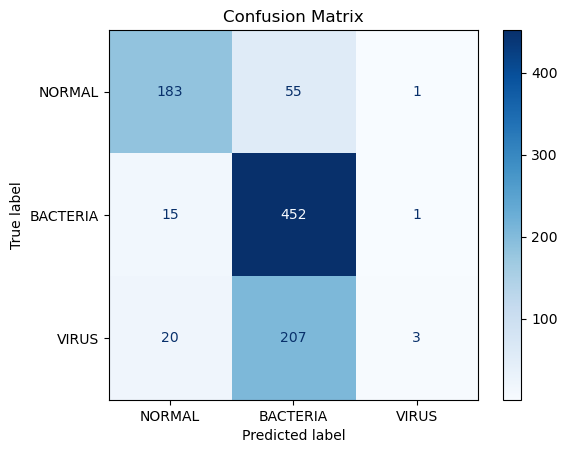

In [95]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the model from checkpoint
model = load_model('model_1_checkpoint.keras')

y_pred_probs = model.predict(X_val_f)  
y_pred_classes = np.argmax(y_pred_probs, axis=1)

acc = accuracy_score(y_val_f, y_pred_classes)
print(f'Accuracy: {acc}')

conf_matrix = confusion_matrix(y_val_f, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

print("Classification Report:\n", classification_report(y_val_f, y_pred_classes, target_names=['NORMAL', 'BACTERIA', 'VIRUS']))

roc_auc = roc_auc_score(y_val_f, y_pred_probs, multi_class='ovr')
print("AUC-ROC Score:", roc_auc)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['NORMAL', 'BACTERIA', 'VIRUS'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

**Model 2. MobileNet**

In [105]:
X_train_f, y_train_f = convert_images_to_arrays('new_resized_224/train', rgb = True, classes=3)
X_test_f, y_test_f = convert_images_to_arrays('new_resized_224/test', rgb= True, classes=3)

  0%|          | 0/9368 [00:00<?, ?it/s]

100%|██████████| 9368/9368 [00:06<00:00, 1535.84it/s]


Total images loaded: 9368, Total labels: 9368


100%|██████████| 2344/2344 [00:01<00:00, 1255.51it/s]


Total images loaded: 2344, Total labels: 2344


In [106]:
from sklearn.model_selection import train_test_split
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(X_train_f, y_train_f, test_size=0.1, random_state=907)
print(f"Training samples: {len(X_train_f)}, Validation samples: {len(X_val_f)}")

Training samples: 8431, Validation samples: 937


In [110]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

IMG_SIZE = 224

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

def get_pretrained_mobilenet():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    output = layers.Dense(3, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=output)
    return model

model_2 = get_pretrained_mobilenet()
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_2.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='min')

model_2.summary()

Model: "functional_182"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,368,515 (12.85 MB)

 Trainable params: 139,651 (545.51 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [111]:
model_2.fit(X_train_f, y_train_f, validation_data=(X_val_f, y_val_f), epochs=10, batch_size=128, callbacks=[reduce_lr, early_stop, model_checkpoint])

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 60s 854ms/step - accuracy: 0.5908 - loss: 3.3769 - val_accuracy: 0.7449 - val_loss: 1.7827 - learning_rate: 0.0010
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 65s 987ms/step - accuracy: 0.7415 - loss: 1.6249 - val_accuracy: 0.7641 - val_loss: 1.2096 - learning_rate: 0.0010
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7586 - loss: 1.1440 - val_accuracy: 0.7673 - val_loss: 0.9641 - learning_rate: 0.0010
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 850ms/step - accuracy: 0.7648 - loss: 0.9346 - val_accuracy: 0.7684 - val_loss: 0.8355 - learning_rate: 0.0010
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 840ms/step - accuracy: 0.7714 - loss: 0.8166 - val_accuracy: 0.7524 - val_loss: 0.7956 - learning_rate: 0.0010
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 54s 810ms/step - accuracy: 0.7663 - loss: 0.7578 - val_accuracy: 0.7545 - val_loss: 0.7397 - learning_rate: 0.0010
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 863ms/step - accuracy: 0.7700 - loss: 0.713

30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step
Accuracy: 0.7524012806830309
Confusion Matrix:
 [[198  37   4]
 [  5 450  13]
 [  5 168  57]]
Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.95      0.83      0.89       239
    BACTERIA       0.69      0.96      0.80       468
       VIRUS       0.77      0.25      0.38       230

    accuracy                           0.75       937
   macro avg       0.80      0.68      0.69       937
weighted avg       0.78      0.75      0.72       937

AUC-ROC Score: 0.9073820343171568


<Figure size 800x600 with 0 Axes>

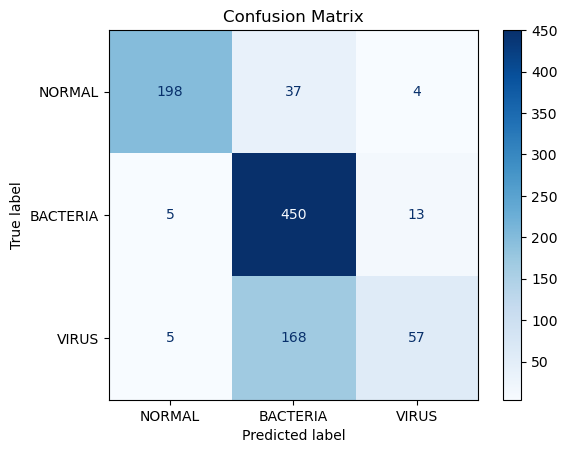

In [113]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the model from checkpoint
model = load_model('model_2.keras')

y_pred_probs = model.predict(X_val_f)  
y_pred_classes = np.argmax(y_pred_probs, axis=1)

acc = accuracy_score(y_val_f, y_pred_classes)
print(f'Accuracy: {acc}')

conf_matrix = confusion_matrix(y_val_f, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

print("Classification Report:\n", classification_report(y_val_f, y_pred_classes, target_names=['NORMAL', 'BACTERIA', 'VIRUS']))

roc_auc = roc_auc_score(y_val_f, y_pred_probs, multi_class='ovr')
print("AUC-ROC Score:", roc_auc)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['NORMAL', 'BACTERIA', 'VIRUS'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

**Model 3. Hierarchical**

In [153]:
X_train_h, y_train_h = convert_images_to_arrays('new_resized_224/train', classes=2)
X_test_h, y_test_h = convert_images_to_arrays('new_resized_224/test', classes = 2)

100%|██████████| 9368/9368 [00:07<00:00, 1206.39it/s]


Total images loaded: 9368, Total labels: 9368


100%|██████████| 2344/2344 [00:01<00:00, 1192.82it/s]


Total images loaded: 2344, Total labels: 2344


In [155]:
from sklearn.model_selection import train_test_split
X_train_h, X_val_h, y_train_h, y_val_h = train_test_split(X_train_h, y_train_h, test_size=0.1, random_state=907)
print(f"Training samples: {len(X_train_h)}, Validation samples: {len(X_val_h)}")

Training samples: 8431, Validation samples: 937


In [156]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

IMG_SIZE = 224

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

def get_pretrained_mobilenet():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    output = layers.Dense(3, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=output)
    return model

model_3 = get_pretrained_mobilenet()
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_3_checkpoint.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='min')

model_3.summary()

Model: "functional_255"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,368,515 (12.85 MB)

 Trainable params: 139,651 (545.51 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [157]:
model_3.fit(X_train_h, y_train_h, epochs=5, batch_size=128, callbacks=[reduce_lr, early_stop, model_checkpoint])

Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 827ms/step - accuracy: 0.8430 - loss: 2.8379 - learning_rate: 0.0010
Epoch 2/5


c:\Users\weem\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
c:\Users\weem\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)
c:\Users\weem\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 49s 737ms/step - accuracy: 0.9349 - loss: 1.1370 - learning_rate: 0.0010
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 51s 774ms/step - accuracy: 0.9423 - loss: 0.6797 - learning_rate: 0.0010
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 51s 775ms/step - accuracy: 0.9380 - loss: 0.4938 - learning_rate: 0.0010
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 834ms/step - accuracy: 0.9424 - loss: 0.3875 - learning_rate: 0.0010


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
model = load_model('model_3_checkpoint.keras')
y_pred_probs = model.predict(X_val_h)  
y_pred_classes = np.argmax(y_pred_probs, axis=1)
acc = accuracy_score(y_val_h, y_pred_classes)
print(f'Accuracy: {acc}')
conf_matrix = confusion_matrix(y_val_h, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_val_h, y_pred_classes, target_names=['NORMAL', 'Sick']))

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step
Accuracy: 0.9306296691568837
Confusion Matrix:
 [[182  57]
 [  8 690]]
Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.96      0.76      0.85       239
        Sick       0.92      0.99      0.96       698

    accuracy                           0.93       937
   macro avg       0.94      0.88      0.90       937
weighted avg       0.93      0.93      0.93       937



In [163]:
X_train_s, y_train_s = convert_images_to_arrays('new_resized_224/train', classes=2, all=False)
X_test_s, y_test_s = convert_images_to_arrays('new_resized_224/test', classes=2, all=False)

100%|██████████| 9368/9368 [00:05<00:00, 1644.46it/s] 


Total images loaded: 6836, Total labels: 6836


100%|██████████| 2344/2344 [00:01<00:00, 1731.27it/s]


Total images loaded: 1710, Total labels: 1710


In [164]:
from sklearn.model_selection import train_test_split
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X_train_s, y_train_s, test_size=0.1, random_state=907)
print(f"Training samples: {len(X_train_s)}, Validation samples: {len(X_val_s)}")

Training samples: 6152, Validation samples: 684


In [165]:
y_train_s = np.where(y_train_s==2, 0, y_train_s)
y_val_s = np.where(y_val_s==2, 0, y_val_s)
y_test_s = np.where(y_test_s==2, 0, y_test_s)

In [166]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

IMG_SIZE = 224

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

base_model.trainable = False

def get_pretrained_mobilenet():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=inputs, outputs=output)
    return model

model_4 = get_pretrained_mobilenet()
model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_4_checkpoint.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='min')

model_4.summary()

Model: "functional_256"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_44 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_19     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,368,385 (12.85 MB)

 Trainable params: 139,521 (545.00 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [177]:
model_4.fit(X_train_s, y_train_s,
    validation_data=(X_val_s, y_val_s),
    epochs=5,
    batch_size=128, 
    callbacks=[reduce_lr, early_stop, model_checkpoint])

Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9481 - loss: 2.5990 - val_accuracy: 1.0000 - val_loss: 1.0887 - learning_rate: 0.0010
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 826ms/step - accuracy: 1.0000 - loss: 0.8827 - val_accuracy: 1.0000 - val_loss: 0.4740 - learning_rate: 0.0010
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 1.0000 - loss: 0.4054 - val_accuracy: 1.0000 - val_loss: 0.2502 - learning_rate: 0.0010
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 1.0000 - loss: 0.2193 - val_accuracy: 1.0000 - val_loss: 0.1455 - learning_rate: 0.0010
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 39s 795ms/step - accuracy: 1.0000 - loss: 0.1301 - val_accuracy: 1.0000 - val_loss: 0.0914 - learning_rate: 0.0010


In [185]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
model = load_model('model_3_checkpoint.keras')
y_pred_probs = model.predict(X_val_s)  
y_pred_classes = np.argmax(y_pred_probs, axis=1)
acc = accuracy_score(y_val_s, y_pred_classes)
print(f'Accuracy: {acc}')
conf_matrix = confusion_matrix(y_val_s, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_val_s, y_pred_classes, target_names=['NORMAL', 'Sick']))

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step
Accuracy: 0.9941520467836257
Confusion Matrix:
 [[  0   0]
 [  4 680]]
Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00         0
        Sick       1.00      0.99      1.00       684

    accuracy                           0.99       684
   macro avg       0.50      0.50      0.50       684
weighted avg       1.00      0.99      1.00       684



c:\Users\weem\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\weem\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\weem\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
